# Day 3: Manual Data Labeling

## Tujuan
Melakukan labeling manual pada data yang sudah dibersihkan dengan kategori:
- **Intent**: complaint, inquiry, urgent_request, feedback
- **Sentiment**: positive, neutral, negative, very_negative
- **Urgency**: low, medium, high, critical
- **Safety**: safe, toxic, offensive

## Output
- `data/labeled/labeled_data.jsonl`: Data berlabel lengkap
- `data/labeled/labeling_stats.json`: Statistik distribusi label

## 1. Setup Environment

In [24]:
import pandas as pd
import json
import jsonlines
import yaml
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Labeling pipeline started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Labeling pipeline started: 2025-12-19 15:21:32


## 2. Load Configuration

In [13]:
# Load configs
config_path = Path('../configs/pipeline_config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

schema_path = Path('../configs/label_schema.json')
with open(schema_path, 'r') as f:
    label_schema = json.load(f)

print("Label Schema:")
for key, value in label_schema['labels'].items():
    print(f"  {key}: {value['options']}")

Label Schema:
  intent: ['complaint', 'inquiry', 'urgent_request', 'feedback']
  sentiment: ['positive', 'neutral', 'negative', 'very_negative']
  urgency: ['low', 'medium', 'high', 'critical']
  safety: ['safe', 'toxic', 'offensive']


## 3. Load Cleaned Data

In [14]:
# Load cleaned data
data_path = Path('../data/processed/cleaned_data.jsonl')
messages = []

with jsonlines.open(data_path) as reader:
    for obj in reader:
        messages.append(obj)

df = pd.DataFrame(messages)
print(f"Loaded {len(df)} messages")
print(f"\nSample:")
print(df.head(3))

Loaded 132 messages

Sample:
        id                                            text  text_length  \
0  msg_117  transaksi gagal tapi duit udh kepotong bangsat           46   
1  msg_355   akun di suspend tiba2 padahal baru top up 1jt           45   
2  msg_301              fitur cicilan 0% masih ada ga min?           34   

  detected_lang  
0            id  
1            id  
2            id  


## 4. Labeling Helper Functions

In [15]:
def auto_label_intent(text):
    """Auto-label intent berdasarkan keywords"""
    text_lower = text.lower()
    
    # Urgent keywords
    if any(word in text_lower for word in ['urgent', 'tolong', 'nyangkut', 'suspend']):
        return 'urgent_request'
    
    # Complaint keywords
    if any(word in text_lower for word in ['gagal', 'error', 'kepotong', 'ilang', 'refund']):
        return 'complaint'
    
    # Inquiry keywords
    if any(word in text_lower for word in ['berapa', 'gimana', 'bisa', 'cara', 'tanya']):
        return 'inquiry'
    
    # Feedback keywords
    if any(word in text_lower for word in ['thanks', 'makasih', 'puas', 'bagus', 'request', 'terima kasih']):
        return 'feedback'
    
    return 'inquiry'

def auto_label_sentiment(text):
    """Auto-label sentiment berdasarkan keywords"""
    text_lower = text.lower()
    
    # Very negative keywords
    if any(word in text_lower for word in ['kontol', 'anjing', 'bangsat', 'tolol', 'brengsek', 'tai']):
        return 'very_negative'
    
    # Negative keywords
    if any(word in text_lower for word in ['gagal', 'error', 'kecewa', 'sampah', 'jelek']):
        return 'negative'
    
    # Positive keywords
    if any(word in text_lower for word in ['thanks', 'makasih', 'puas', 'lancar', 'cepet']):
        return 'positive'
    
    return 'neutral'

def auto_label_urgency(text):
    """Auto-label urgency berdasarkan keywords dan tanda seru"""
    text_lower = text.lower()
    exclamation_count = text.count('!')
    
    # Critical: urgent + banyak tanda seru atau nominal besar
    if 'urgent' in text_lower and (exclamation_count >= 3 or any(x in text_lower for x in ['jt', 'suspend'])):
        return 'critical'
    
    # High: urgent atau banyak tanda seru
    if 'urgent' in text_lower or exclamation_count >= 3:
        return 'high'
    
    # Add suspend as high priority keyword
    if any(word in text_lower for word in ['suspend', 'banned', 'block']):
        return 'high'
    
    # Time-sensitive complaints
    if any(word in text_lower for word in ['hari', 'minggu', 'bulan']):
        return 'medium'
    
    # Medium: ada complaint
    if any(word in text_lower for word in ['gagal', 'error', 'kepotong', 'ilang']):
        return 'medium'
    
    return 'low'

def auto_label_safety(text):
    """Auto-label safety berdasarkan toxic words"""
    text_lower = text.lower()
    
    # Toxic words
    toxic_words = ['kontol', 'anjing', 'bangsat', 'tolol', 'brengsek']
    if any(word in text_lower for word in toxic_words):
        return 'toxic'
    
    # Offensive words
    offensive_words = ['goblok', 'tai', 'sampah']
    if any(word in text_lower for word in offensive_words):
        return 'offensive'
    
    return 'safe'

print("Labeling functions ready")

Labeling functions ready


## 5. Apply Auto-Labeling

In [16]:
print("Applying auto-labeling...\n")

# Apply labeling functions
df['intent'] = df['text'].apply(auto_label_intent)
df['sentiment'] = df['text'].apply(auto_label_sentiment)
df['urgency'] = df['text'].apply(auto_label_urgency)
df['safety'] = df['text'].apply(auto_label_safety)

print("Labeling completed!")
print(f"\nSample labeled data:")
print(df[['id', 'text', 'intent', 'sentiment', 'urgency', 'safety']].head())

Applying auto-labeling...

Labeling completed!

Sample labeled data:
        id                                            text          intent  \
0  msg_117  transaksi gagal tapi duit udh kepotong bangsat       complaint   
1  msg_355   akun di suspend tiba2 padahal baru top up 1jt  urgent_request   
2  msg_301              fitur cicilan 0% masih ada ga min?         inquiry   
3  msg_516        limit transfer gopay berapa sih maksimal         inquiry   
4  msg_331               min request fitur split bill dong        feedback   

       sentiment urgency safety  
0  very_negative  medium  toxic  
1        neutral    high   safe  
2        neutral     low   safe  
3        neutral     low   safe  
4        neutral     low   safe  


## 6. Label Distribution Statistics

In [17]:
print("\n=== LABEL DISTRIBUTION ===")

stats = {
    'total_messages': len(df),
    'timestamp': datetime.now().isoformat(),
    'distributions': {}
}

for label_type in ['intent', 'sentiment', 'urgency', 'safety']:
    dist = df[label_type].value_counts().to_dict()
    stats['distributions'][label_type] = dist
    
    print(f"\n{label_type.upper()}:")
    for value, count in dist.items():
        percentage = (count / len(df)) * 100
        print(f"  {value}: {count} ({percentage:.1f}%)")


=== LABEL DISTRIBUTION ===

INTENT:
  inquiry: 47 (35.6%)
  complaint: 39 (29.5%)
  urgent_request: 30 (22.7%)
  feedback: 16 (12.1%)

SENTIMENT:
  neutral: 71 (53.8%)
  very_negative: 36 (27.3%)
  negative: 18 (13.6%)
  positive: 7 (5.3%)

URGENCY:
  low: 63 (47.7%)
  medium: 27 (20.5%)
  high: 27 (20.5%)
  critical: 15 (11.4%)

SAFETY:
  safe: 91 (68.9%)
  toxic: 31 (23.5%)
  offensive: 10 (7.6%)


## 7. Visualize Label Distribution

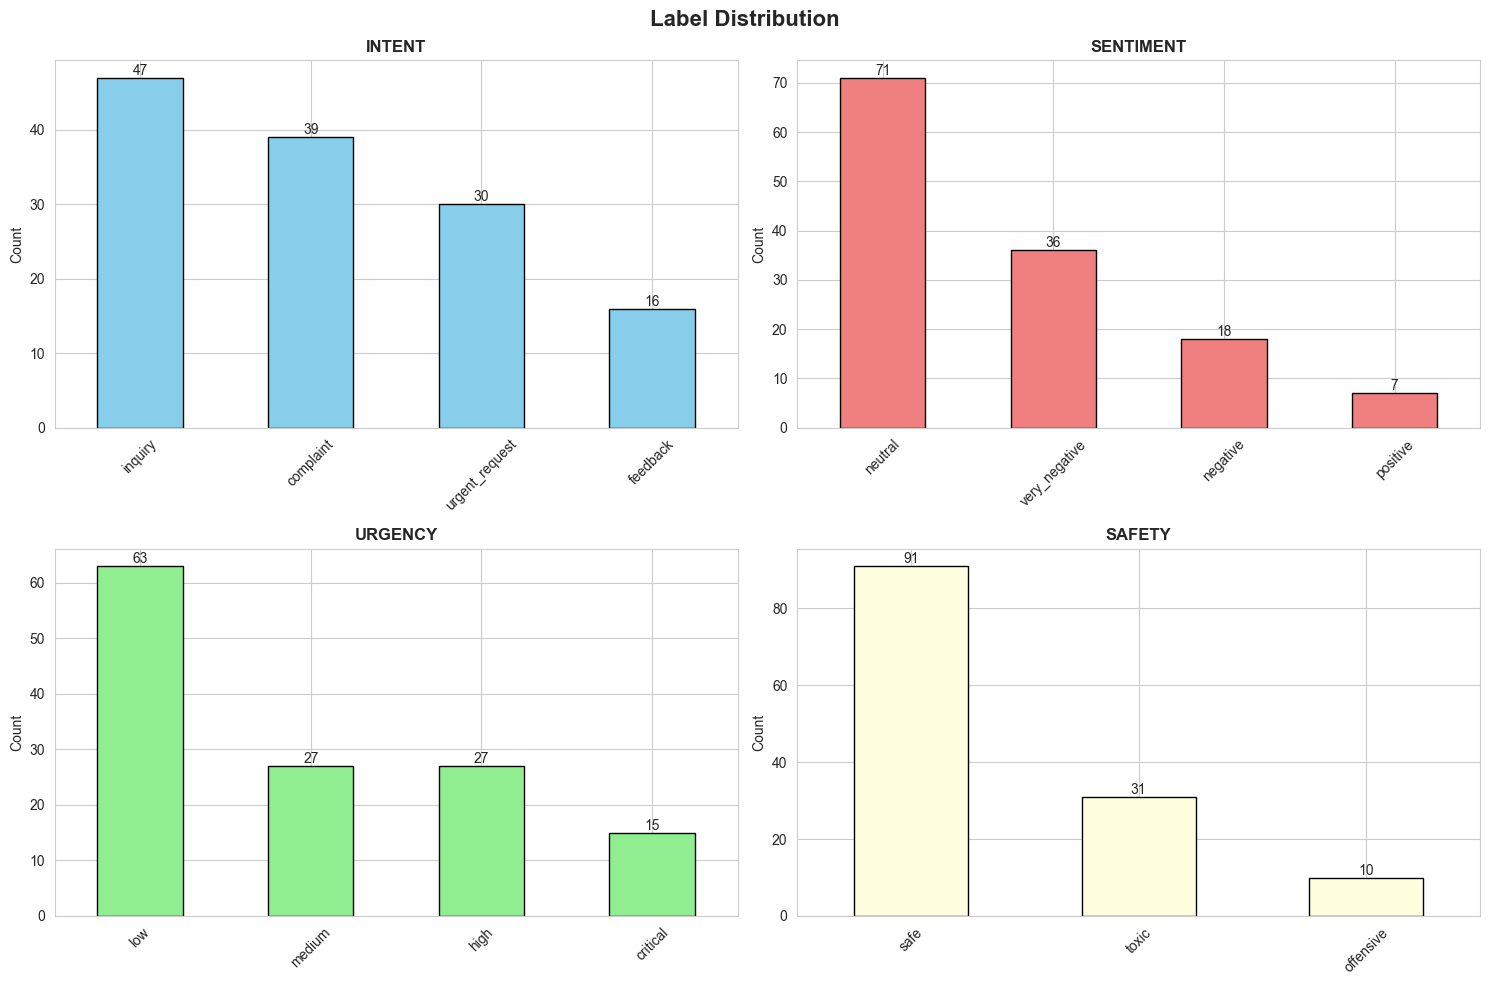

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Label Distribution', fontsize=16, fontweight='bold')

label_types = ['intent', 'sentiment', 'urgency', 'safety']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow']

for idx, (label_type, color) in enumerate(zip(label_types, colors)):
    ax = axes[idx // 2, idx % 2]
    
    data = df[label_type].value_counts()
    data.plot(kind='bar', ax=ax, color=color, edgecolor='black')
    
    ax.set_title(label_type.upper(), fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d')

plt.tight_layout()
viz_dir = Path('../outputs/visualizations')
viz_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(viz_dir / '03_label_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

## 8. Export Labeled Data

In [19]:
print("\n=== EXPORT LABELED DATA ===")

# Create output directory
output_dir = Path('../data/labeled')
output_dir.mkdir(parents=True, exist_ok=True)

# Export to JSONL
output_jsonl = output_dir / 'labeled_data.jsonl'
with jsonlines.open(output_jsonl, 'w') as writer:
    for _, row in df.iterrows():
        writer.write({
            'id': row['id'],
            'text': row['text'],
            'text_length': int(row['text_length']),
            'detected_lang': row['detected_lang'],
            'labels': {
                'intent': row['intent'],
                'sentiment': row['sentiment'],
                'urgency': row['urgency'],
                'safety': row['safety']
            }
        })

print(f"Labeled data exported: {output_jsonl}")
print(f"  Total records: {len(df)}")

# Save statistics
stats_path = output_dir / 'labeling_stats.json'
with open(stats_path, 'w', encoding='utf-8') as f:
    json.dump(stats, f, indent=2, ensure_ascii=False)

print(f"\nStatistics saved: {stats_path}")


=== EXPORT LABELED DATA ===
Labeled data exported: ..\data\labeled\labeled_data.jsonl
  Total records: 132

Statistics saved: ..\data\labeled\labeling_stats.json


## 9. Sample Labeled Messages

In [20]:
print("\n=== LABELED MESSAGE SAMPLES ===")
print("="*80)

for _, row in df.sample(min(10, len(df))).iterrows():
    print(f"\n[{row['id']}] {row['text'][:60]}...")
    print(f"  Intent: {row['intent']} | Sentiment: {row['sentiment']}")
    print(f"  Urgency: {row['urgency']} | Safety: {row['safety']}")
    print("-" * 80)


=== LABELED MESSAGE SAMPLES ===

[msg_120] saldo tiba2 berkurang sendiri aplikasi sampah???...
  Intent: inquiry | Sentiment: negative
  Urgency: low | Safety: offensive
--------------------------------------------------------------------------------

[msg_042] REFUND GW MANA KONTOL UDAH SEMINGGU...
  Intent: complaint | Sentiment: very_negative
  Urgency: medium | Safety: toxic
--------------------------------------------------------------------------------

[msg_405] URGENT!!! saldo 3jt ga bisa dipake akun error...
  Intent: urgent_request | Sentiment: negative
  Urgency: critical | Safety: safe
--------------------------------------------------------------------------------

[msg_267] gopay sama ovo bagusan mana ya???...
  Intent: feedback | Sentiment: neutral
  Urgency: low | Safety: safe
--------------------------------------------------------------------------------

[msg_204] bisa ga sih naikin limit gw...
  Intent: inquiry | Sentiment: neutral
  Urgency: low | Safety: safe
---

## 10. Cross-Label Analysis

In [21]:
print("\n=== CROSS-LABEL ANALYSIS ===")

# Intent vs Sentiment
print("\nIntent vs Sentiment:")
cross_tab = pd.crosstab(df['intent'], df['sentiment'])
print(cross_tab)

# Safety Distribution
print("\n\nSafety Distribution:")
safety_dist = df['safety'].value_counts()
for category, count in safety_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {category}: {count} ({percentage:.1f}%)")

# Urgent + Toxic messages
urgent_toxic = df[(df['urgency'].isin(['high', 'critical'])) & 
                   (df['safety'].isin(['toxic', 'offensive']))]
print(f"\n\nUrgent + Toxic/Offensive messages: {len(urgent_toxic)} ({len(urgent_toxic)/len(df)*100:.1f}%)")


=== CROSS-LABEL ANALYSIS ===

Intent vs Sentiment:
sentiment       negative  neutral  positive  very_negative
intent                                                    
complaint              4        0         3             32
feedback               0       12         4              0
inquiry                8       39         0              0
urgent_request         6       20         0              4


Safety Distribution:
  safe: 91 (68.9%)
  toxic: 31 (23.5%)
  offensive: 10 (7.6%)


Urgent + Toxic/Offensive messages: 10 (7.6%)


## 11. Completion Summary

In [22]:
print("\n" + "="*60)
print("LABELING PIPELINE COMPLETED")
print("="*60)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nOutputs generated:")
print(f"  1. {output_jsonl}")
print(f"  2. {stats_path}")
print(f"  3. {viz_dir}/03_label_distribution.png")
print(f"\nLabeled messages: {len(df)}")
print(f"\nLabel categories:")
print(f"  - Intent: {len(df['intent'].unique())} categories")
print(f"  - Sentiment: {len(df['sentiment'].unique())} categories")
print(f"  - Urgency: {len(df['urgency'].unique())} categories")
print(f"  - Safety: {len(df['safety'].unique())} categories")
print("\nNext step: Day 4 - Model training & evaluation")
print("="*60)


LABELING PIPELINE COMPLETED
Timestamp: 2025-12-19 10:51:02

Outputs generated:
  1. ..\data\labeled\labeled_data.jsonl
  2. ..\data\labeled\labeling_stats.json
  3. ..\outputs\visualizations/03_label_distribution.png

Labeled messages: 132

Label categories:
  - Intent: 4 categories
  - Sentiment: 4 categories
  - Urgency: 4 categories
  - Safety: 3 categories

Next step: Day 4 - Model training & evaluation
